In [ ]:
import tensorflow as tf

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture as GMM

import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
import torch


In [ ]:
# import splitfolders
import tensorflow as tf
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

/device:GPU:0
Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = r"/content/drive/MyDrive/PFE ENSTA BRETAGNE/mstar/TRAIN"
test = r"/content/drive/MyDrive/PFE ENSTA BRETAGNE/mstar/TEST"

In [ ]:
cat_counts = {}
for cat in os.listdir(train):
    counts = len(os.listdir(os.path.join(train, cat)))
    cat_counts[cat] =counts
print(cat_counts)

{'classe3': 298, 'classe9': 299, 'classe10': 299, 'classe5': 233, 'classe2': 233, 'classe7': 299, 'classe8': 232, 'classe1': 292, 'classe4': 256, 'classe6': 299}


In [ ]:
cat_counts = {}
for cat in os.listdir(test):
    counts = len(os.listdir(os.path.join(test, cat)))
    cat_counts[cat] =counts
print(cat_counts)

{'classe8': 196, 'classe7': 273, 'classe3': 274, 'classe6': 274, 'classe9': 274, 'classe1': 274, 'classe2': 195, 'classe4': 195, 'classe5': 196, 'classe10': 274}


In [ ]:
PATH1=r'/content/drive/MyDrive/dataset.pt'
PATH2='/content/drive/MyDrive/datatest.pt'

In [ ]:
import torch

In [ ]:
dataset=torch.load(PATH1)
datatest=torch.load(PATH2)

In [ ]:
x_train,y_train=zip(*dataset)
x_test, y_test=zip(*datatest)
y_train=to_categorical(y_train)
x_train=np.array(x_train)
y_test=to_categorical(y_test)
x_test=np.array(x_test)

In [ ]:
x_test.shape

(2425, 128, 128, 1)

In [ ]:
#### Normalize
#### Normalize
norm_train = np.float32(x_train)/255.00
norm_test = np.float32(x_test)/255.00
n_images = x_train.shape[0]
indexes = np.random.randint(0, norm_train.shape[0],size=n_images)
images = norm_train[indexes]

In [ ]:
### Center datasets for PCA

images = np.float32(images)
mu = np.mean(images)
std = np.std(images)
images -= mu
images /= std
pca_input = np.reshape(images,(-1,n_images))

In [ ]:
#### DO the PCA

n = 100
pca_ = PCA(n_components=n)
principalComponents = pca_.fit_transform(pca_input)
recon = pca_.inverse_transform(principalComponents)
mse = mean_squared_error(pca_input, recon,squared=True)
print(f"MSE: {mse} with {n} components")



MSE: 0.4748169779777527 with 100 components


In [ ]:
principalComponents.shape

(16384, 100)

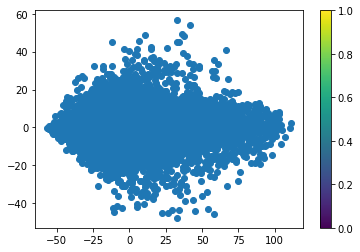

In [ ]:
plt.figure()
plt.scatter(principalComponents[:, 0], principalComponents[:, 1],cmap="Paired")
plt.colorbar()

In [ ]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm=gmm.fit(principalComponents )
labels = gmm.predict(principalComponents )

In [ ]:
gmm = GMM(n_components=2, covariance_type='full', random_state=42)
plot_gmm(gmm,  principalComponents)

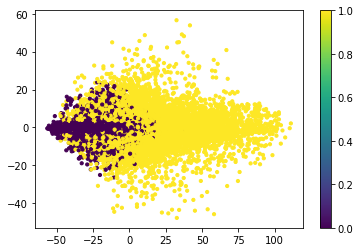

In [ ]:
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=labels, s=10, cmap='viridis');
plt.colorbar()

In [ ]:
probs = gmm.predict_proba(principalComponents)
probs

array([[8.60684042e-01, 1.39315958e-01],
       [1.83700555e-20, 1.00000000e+00],
       [2.12318293e-82, 1.00000000e+00],
       ...,
       [3.38667714e-15, 1.00000000e+00],
       [1.00000000e+00, 1.16146966e-24],
       [1.00000000e+00, 3.66729852e-25]])

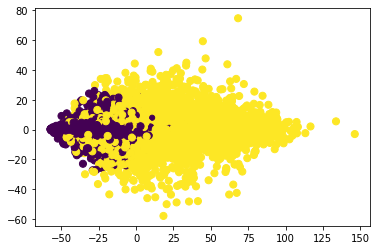

In [ ]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=labels, cmap='viridis', s=size)

In [ ]:

#POUR VERIFIER LE NUMBER DES CLUSTERS 
Sum_bic = []
Sum_aic = []

K = range(1,10)
for k in K:
    gmm = GaussianMixture(n_components=k)
    gmm = gmm.fit(principalComponents)
    Sum_bic.append(gmm.bic(principalComponents))
    Sum_aic.append(gmm.aic(principalComponents))

/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


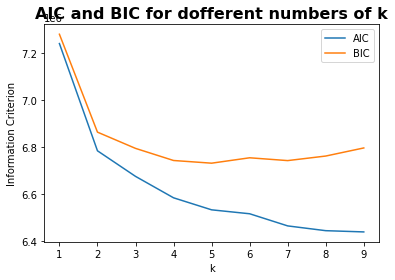

In [ ]:
x1 = K
y1 = Sum_aic
plt.plot(x1, y1, label = "AIC")
x2 = K
y2 = Sum_bic
plt.plot(x2, y2, label = "BIC")

plt.title("AIC and BIC for dofferent numbers of k", fontsize=16, fontweight='bold')
plt.xlabel("k")
plt.ylabel("Information Criterion")
plt.legend(loc='upper right')
plt.show()

In [ ]:
Z= gmm.sample(100)[1]

In [ ]:
Z.size

100

In [ ]:
Z.shape

(100,)

In [ ]:
batch_size=100
nz = 100

In [ ]:

def get_noise(batch_size, noise_code):
  if noise_code == "normal":

    return torch.randn( (batch_size, nz, 1, 1), dtype = torch.float )

  elif noise_code == "normal_naive_pca":

    out = np.random.normal(noise_mean, noise_std, size = (batch_size,nz))
    return torch.tensor(out, dtype=torch.float).view(batch_size,nz,1,1)

  elif noise_code == "normal_multivar_pca":

    out = np.random.multivariate_normal(noise_mean, noise_cov, size = (batch_size))
    return torch.tensor(out, dtype=torch.float).view(batch_size,nz,1,1)

  elif noise_code =="gm_pca":
      return torch.tensor(gmm.sample(batch_size)[0], dtype=torch.float).view(batch_size,nz,1,1)
  else:
    return None

In [ ]:
z=np.array(Z)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [ ]:
train_images= x_train

In [ ]:
train_images.shape

(2192, 128, 128, 1)

In [ ]:
 BUFFER_SIZE = 60000
 BATCH_SIZE = 32

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(type(train_dataset))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display
from keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
import os

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=Z.shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())



    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    #assert model.output_shape == (None, 128, 128)
  
    return model


In [ ]:
generator = make_generator_model()



tf.Tensor(
[[ 8.1181577e-05  1.9326856e-04  1.0446807e-04 ...  1.5401064e-03
   1.5866090e-04 -8.1591075e-05]
 [-2.6618692e-04  4.1224179e-04 -4.2400075e-04 ...  2.4343401e-03
  -2.1021925e-03 -1.1695470e-03]
 [ 6.1845669e-04  8.4821240e-04  2.5687943e-04 ... -2.3591856e-05
   8.7336428e-04  1.8040186e-03]
 ...
 [ 1.0293593e-03  2.6421752e-03 -1.9572355e-04 ...  1.6919781e-02
  -5.0982847e-03  1.2718179e-02]
 [ 8.8712818e-04 -5.8394467e-04  5.0855457e-04 ...  5.3376984e-03
   1.9722898e-04  1.0857731e-03]
 [ 1.7779352e-04 -7.4575312e-04 -1.3194552e-03 ... -5.6553851e-03
   3.1007722e-03  2.5548367e-04]], shape=(128, 128), dtype=float32)


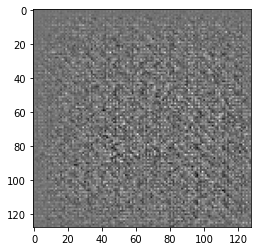

In [ ]:
noise = gmm.sample(100)[0]
generated_image = generator(noise, training=False)
print(generated_image[0, :, :, 0])
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_5 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 8, 8, 128)        

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same',
                                      input_shape=(128, 128,1)))
                            
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor(
[[-5.6894956e-04]
 [-5.0579489e-04]
 [ 2.9420332e-04]
 [ 8.1028527e-04]
 [ 7.0295669e-04]
 [ 5.3538295e-04]
 [ 7.6390372e-04]
 [ 5.5459031e-04]
 [ 9.3624071e-04]
 [ 8.2403934e-04]
 [ 2.8235407e-04]
 [ 5.9577357e-04]
 [ 4.2282525e-04]
 [ 3.9491622e-04]
 [-3.4594443e-04]
 [-9.9773461e-04]
 [-1.9764225e-04]
 [-1.8826232e-04]
 [-6.8247842e-04]
 [-2.0842191e-03]
 [-2.5031953e-03]
 [-1.5110926e-04]
 [-3.1465059e-04]
 [-6.2958180e-04]
 [-7.5981696e-04]
 [-4.2184454e-04]
 [-2.4021876e-03]
 [-2.0227532e-03]
 [-2.8264448e-03]
 [-2.4833137e-04]
 [-1.0098693e-03]
 [-1.4019122e-03]
 [-2.3800078e-04]
 [-3.7983686e-03]
 [-1.2016167e-03]
 [-1.0374780e-03]
 [-1.1963374e-03]
 [-1.8659915e-03]
 [-9.4540283e-04]
 [-9.3889312e-04]
 [ 2.0484149e-03]
 [-7.0905464e-04]
 [-1.3985940e-03]
 [ 3.8450953e-04]
 [-3.8109789e-05]
 [ 5.7504489e-04]
 [ 1.8894774e-04]
 [ 3.2603835e-05]
 [ 6.6512736e-04]
 [ 3.8414093e-04]
 [ 6.9401911e-05]
 [ 1.0427309e-04]
 [ 9.8935816e-05]
 [ 8.1854130e-05]
 [ 1.1604648e-03]

In [ ]:
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 64)      1664      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       204928    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 64, 64, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 64, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 524288)           

In [ ]:

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 500
# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
noise = gmm.sample(100)[0]

In [ ]:
# tf.function annotation causes the function 
# to be "compiled" as part of the training
@tf.function
def train_step(images):
  
    # 1 - Create a random noise to feed it into the model
    # for the image generation
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # 3 - Calculate gradients using loss values and model variables
    # "gradient" method computes the gradient using 
    # operations recorded in context of this tape (gen_tape and disc_tape).
    
    # It accepts a target (e.g., gen_loss) variable and 
    # a source variable (e.g.,generator.trainable_variables)
    # target --> a list or nested structure of Tensors or Variables to be differentiated.
    # source --> a list or nested structure of Tensors or Variables.
    # target will be differentiated against elements in sources.

    # "gradient" method returns a list or nested structure of Tensors  
    # (or IndexedSlices, or None), one for each element in sources. 
    # Returned structure is the same as the structure of sources.
    gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)
    
    # 4 - Process  Gradients and Run the Optimizer
    # "apply_gradients" method processes aggregated gradients. 
    # ex: optimizer.apply_gradients(zip(grads, vars))
    """
    Example use of apply_gradients:
    grads = tape.gradient(loss, vars)
    grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
    # Processing aggregated gradients.
    optimizer.apply_gradients(zip(grads, vars), experimental_aggregate_gradients=False)
    """
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs):
  # A. For each epoch, do the following:
  for epoch in range(epochs):
    start = time.time()
    # 1 - For each batch of the epoch, 
    for image_batch in dataset:
      # 1.a - run the custom "train_step" function
      # we just declared above
      train_step(image_batch)

    # 2 - Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 3 - Save the model every 5 epochs as 
    # a checkpoint, which we will use later
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # 4 - Print out the completed epoch no. and the time spent
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # B. Generate a final image after the training is completed
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  # 1 - Generate images
  predictions = model(test_input, training=False)
  # 2 - Plot the generated images
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  # 3 - Save the generated images
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
train(train_dataset, EPOCHS)